In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
# import mplfinance as mpf
# from statsmodels.tsa.stattools import adfuller # used to check stationarity
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # ACF and PACF Plots
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from prophet import Prophet

In [2]:
data = pd.read_csv("BTC-USD.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close', 'Volume']]  # Keep relevant columns
data.dropna(inplace=True)

In [4]:
data.head()

,Close,Volume
Date,,
2014-09-17,457.334015,21056800
2014-09-18,424.440002,34483200
2014-09-19,394.795990,37919700
2014-09-20,408.903992,36863600
2014-09-21,398.821014,26580100


In [5]:
data.columns

Index(['Close', 'Volume'], dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2755 entries, 2014-09-17 to 2022-04-02
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2755 non-null   float64
 1   Volume  2755 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 64.6 KB


<Axes: xlabel='Date'>

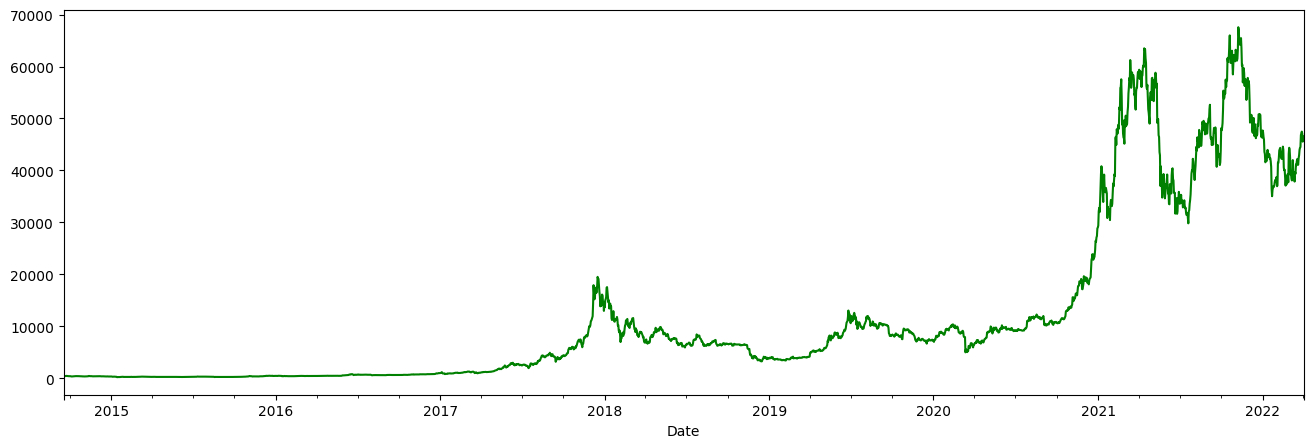

In [7]:
# line plot of Closed price
data['Close'].plot(figsize=(16,5), color = 'g') 

<Axes: xlabel='Date'>

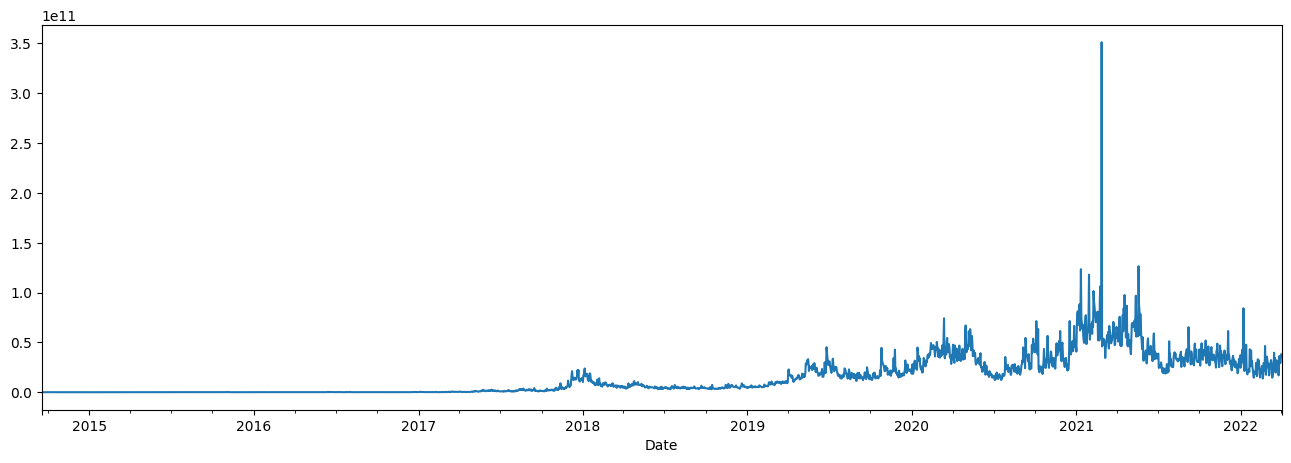

In [8]:
# line plot of volume
data['Volume'].plot(figsize=(16,5)) 

<Axes: ylabel='Frequency'>

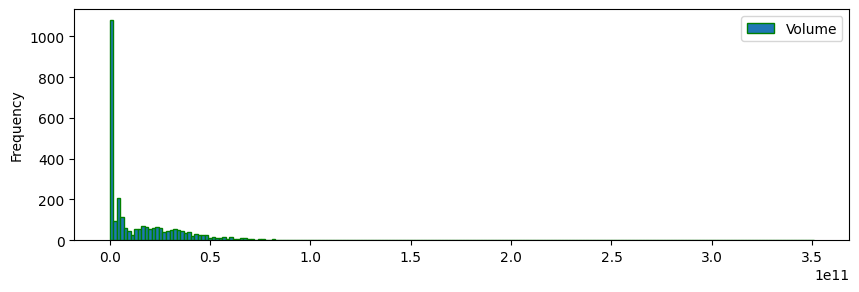

In [9]:
# histogram 
data.plot.hist(y='Volume', figsize=(10,3),bins=200,edgecolor='g')

In [10]:
# Split the dataset
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [11]:
# PROPHET MODEL
# Prepare the data for Prophet
prophet_data = train.reset_index()[['Date', 'Close']]
prophet_data.columns = ['ds', 'y']
prophet_data['Volume'] = train['Volume'].values  # Add volume as regressor

In [12]:
# Initialize and fit Prophet model
prophet_model = Prophet()
prophet_model.add_regressor('Volume')
prophet_model.fit(prophet_data)

21:05:57 - cmdstanpy - INFO - Chain [1] start processing
21:05:58 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
# Prepare test data
prophet_test = test.reset_index()[['Close', 'Volume']]
prophet_test.columns = ['y', 'Volume']
prophet_future = test.reset_index()[['Date', 'Volume']]
prophet_future.columns = ['ds', 'Volume']

In [14]:
# Predict and evaluate Prophet model
prophet_forecast = prophet_model.predict(prophet_future)
prophet_preds = prophet_forecast['yhat']

In [15]:
# Calculate RMSE for Prophet
prophet_rmse = sqrt(mean_squared_error(test['Close'], prophet_preds))
print(f"Prophet RMSE: {prophet_rmse}")

Prophet RMSE: 34248.69022127816


In [16]:
# SARIMAX MODEL
# Fit SARIMAX model
sarimax_model = SARIMAX(train['Close'], 
                        order=(1, 1, 1), 
                        seasonal_order=(1, 1, 1, 12), 
                        exog=train[['Volume']])
sarimax_result = sarimax_model.fit(disp=False)

c:\Users\neera\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\neera\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\neera\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [17]:
# Forecast using SARIMAX
sarimax_forecast = sarimax_result.forecast(steps=len(test), exog=test[['Volume']])
sarimax_rmse = sqrt(mean_squared_error(test['Close'], sarimax_forecast))
print(f"SARIMAX RMSE: {sarimax_rmse}")

SARIMAX RMSE: 35276.65593458165


In [18]:
# LSTM MODEL
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [19]:
# Prepare data for LSTM
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 60
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
X_train, y_train = create_dataset(train_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

In [20]:
# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [21]:
# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\neera\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
# Train LSTM
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0195
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0012
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 9.0301e-04
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 8.0142e-04
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 6.9262e-04
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 6.3182e-04
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 7.1045e-04
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 6.1894e-04
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 5.0576e-04
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 5.0679e-04
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 4.3823e-04
Epoch 12/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 5.4042e-04
Epoch 13/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 4.3190e-04
Epoch 14/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 4.9698e-04
Epoch 15/20
67/67 ━━━━━

In [23]:
# Predict and evaluate
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(np.concatenate((lstm_predictions, np.zeros((lstm_predictions.shape[0], 1))), axis=1))[:, 0]
lstm_rmse = sqrt(mean_squared_error(test[look_back + 1:]['Close'], lstm_predictions))
print(f"LSTM RMSE: {lstm_rmse}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
LSTM RMSE: 6988.076852353835


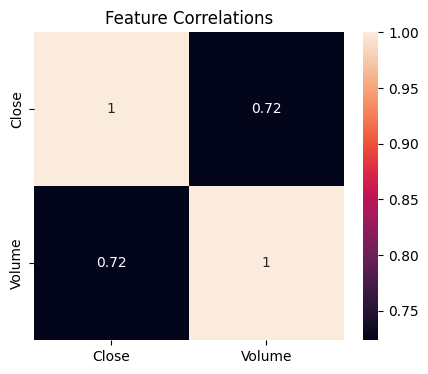

In [24]:
# Correlation Heatmap
plt.figure(figsize=(5,4))
sns.heatmap(data.corr(), annot=True)
plt.title("Feature Correlations")
plt.show()

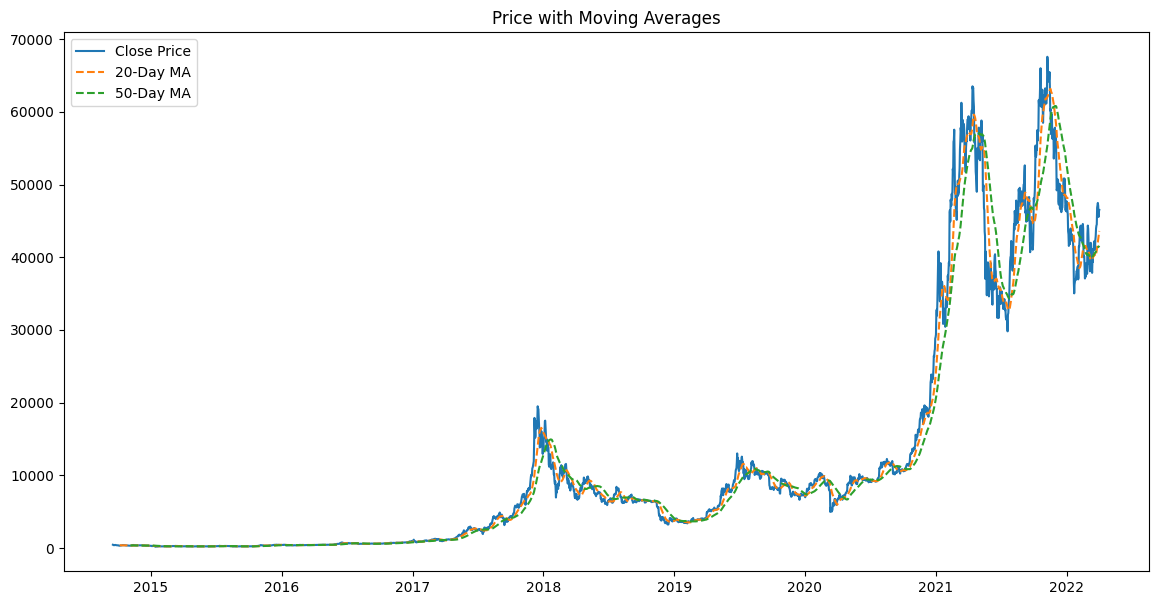

In [25]:
# Moving Averages
plt.figure(figsize=(14, 7))
data['Short_MA'] = data['Close'].rolling(window=20).mean()
data['Long_MA'] = data['Close'].rolling(window=50).mean()
plt.plot(data.index, data['Close'], label='Close Price')
plt.plot(data.index, data['Short_MA'], label='20-Day MA', linestyle='--')
plt.plot(data.index, data['Long_MA'], label='50-Day MA', linestyle='--')
plt.legend()
plt.title("Price with Moving Averages")
plt.show()

In [26]:
# 'Close' column for analysis
time_series = data['Close']

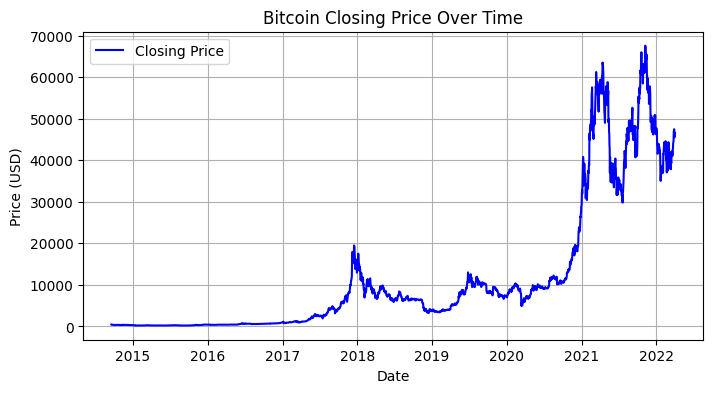

In [27]:
# 1. Visualizing the time series in one frame
plt.figure(figsize=(8,4))
plt.plot(time_series, label='Closing Price', color='blue')
plt.title('Bitcoin Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

Objective: The project aimed to predict Bitcoin prices using three models—Prophet, SARIMAX, and LSTM—by analyzing historical price and volume data.

Best Model: The LSTM model outperformed the others with the lowest RMSE (6,988.08), showing its ability to capture complex patterns in time-series data.

Data Preprocessing: Key steps included handling missing values, normalizing the data for LSTM, and incorporating volume as an additional feature for Prophet and SARIMAX models.

Model Evaluation: The models were evaluated using RMSE, with Prophet (34,248.69) and SARIMAX (35,276.66) showing higher errors compared to LSTM, which indicated better predictive accuracy.

Insights: Bitcoin price forecasting is complex due to volatility, but using advanced models like LSTM, along with features such as volume and moving averages, provides valuable insights into price movements.